# ML mini project
## Classification task on the Cifar10 color image dataset using a CNN

## Setup

In [1]:
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the data

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


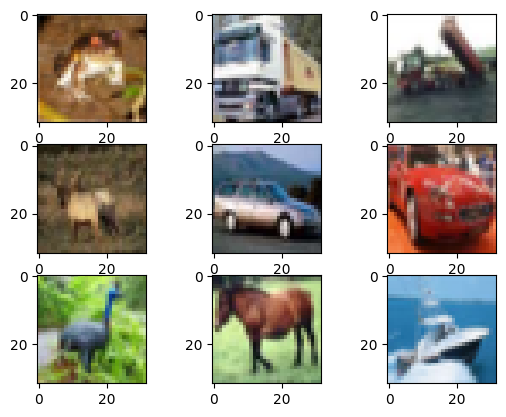

In [2]:


# load dataset
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train_full.shape, y_train_full.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train_full[i])
# show the figure
plt.show()

In [3]:
# Split the full training set into a validation set and a (smaller) training set,
# and scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [4]:
X_valid.dtype

dtype('float64')

In [5]:
y_train

array([[6],
       [7],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [6]:
print('Validation: X=%s, y=%s' % (X_valid.shape, y_valid.shape))
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))

Validation: X=(5000, 32, 32, 3), y=(5000, 1)
Train: X=(45000, 32, 32, 3), y=(45000, 1)


In [7]:
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

In [8]:
y_train.shape

(45000, 1)

## BuildModel method

In [9]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

In [10]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from typing import Dict, Iterable, Any

In [11]:
def build_and_compile_model(startingFilters = 32, n_layers = 1 ):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(startingFilters, kernel_size=3, activation='relu', padding="same", 
                        input_shape=[32, 32, 3]))
    model.add(keras.layers.Conv2D(startingFilters, kernel_size=3, activation='relu', padding="same"))
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    if(n_layers > 1):
        for layer in range(n_layers - 1):
            startingFilters *= 2
            model.add(keras.layers.Conv2D(startingFilters, kernel_size=3, activation='relu', padding="same"))
            model.add(keras.layers.Conv2D(startingFilters, kernel_size=3, activation='relu', padding="same"))
            model.add(keras.layers.MaxPooling2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(units=10, activation='softmax'))

# You must at least specify the loss function and the optimizer to use. 
# You can also specify a list of additional metrics to use during training and evaluation.
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

    return model

    




## Create a CNN With 1 VGG layer
"VGG is a classical convolutional neural network architecture. It was based on an analysis of how to increase the depth of such networks. The network utilises small 3 x 3 filters. Otherwise the network is characterized by its simplicity: the only other components being pooling layers and a fully connected layer."
https://paperswithcode.com/method/vgg last visited 09/12/2022

In [12]:
model = build_and_compile_model(32,1)

### Show information about the model

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

### Train the model

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Define hyperparameter sets and ranges to explore
param_distribs = {
    "startingFilters": [ 32, 64, 128],
    "n_layers": [ 1, 2, 3]
}
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

keras_classifier = KerasClassifier(build_and_compile_model, startingFilters=param_distribs["startingFilters"], n_layers=param_distribs["n_layers"])

rand_search_cv = RandomizedSearchCV(keras_classifier, param_distribs, n_jobs=1, cv=4, n_iter= 4)
# Search
rand_search_cv.fit(X_train, y_train, epochs=20,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
1055/1055 [==============================] - 18s 8ms/step - loss: 2.2452 - accuracy: 0.1418 - val_loss: 2.0910 - val_accuracy: 0.2208
Epoch 2/20
1055/1055 [==============================] - 8s 8ms/step - loss: 1.9413 - accuracy: 0.2620 - val_loss: 1.6922 - val_accuracy: 0.3586
Epoch 3/20
1055/1055 [==============================] - 8s 8ms/step - loss: 1.6766 - accuracy: 0.3700 - val_loss: 1.4403 - val_accuracy: 0.4680
Epoch 4/20
1055/1055 [==============================] - 8s 8ms/step - loss: 1.5120 - accuracy: 0.4435 - val_loss: 1.3318 - val_accuracy: 0.5318
Epoch 5/20
1055/1055 [==============================] - 9s 8ms/step - loss: 1.3611 - accuracy: 0.5110 - val_loss: 1.1809 - val_accuracy: 0.5926
Epoch 6/20
1055/1055 [==============================] - 8s 8ms/step - loss: 1.2209 - accuracy: 0.5722 - val_loss: 1.0671 - val_accuracy: 0.6332
Epoch 7/20
1055/1055 [==============================] - 8s 8ms/step - loss: 1.1145 - accuracy: 0.6169 - val_loss: 0.9561 - val_accuracy

RandomizedSearchCV(cv=4,
                   estimator=KerasClassifier(model=<function build_and_compile_model at 0x000002A4B9895AF0>, n_layers=[1, 2, 3], startingFilters=[32, 64, 128]),
                   n_iter=4, n_jobs=1,
                   param_distributions={'n_layers': [1, 2, 3],
                                        'startingFilters': [32, 64, 128]})

In [28]:
rand_search_cv.best_params_



{'n_layers': 1, 'startingFilters': 32}

In [20]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

AttributeError: 'function' object has no attribute 'history'

### Evaluate the model

In [ ]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.0841 - accuracy: 0.6457


[1.0840972661972046, 0.6456999778747559]

## Create a CNN With 2 VGG layer's

In [ ]:
model = build_and_compile_model(32,2)

### Show information about the model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

### Train the model

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1407/1407 [==============================] - 10s 7ms/step - loss: 2.0400 - accuracy: 0.2251 - val_loss: 1.6178 - val_accuracy: 0.4368
Epoch 2/20
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6373 - accuracy: 0.3951 - val_loss: 1.3228 - val_accuracy: 0.5148
Epoch 3/20
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4154 - accuracy: 0.4923 - val_loss: 1.1739 - val_accuracy: 0.5886
Epoch 4/20
1407/1407 [==============================] - 9s 6ms/step - loss: 1.2797 - accuracy: 0.5485 - val_loss: 1.1247 - val_accuracy: 0.6002
Epoch 5/20
1407/1407 [==============================] - 9s 6ms/step - loss: 1.1848 - accuracy: 0.5894 - val_loss: 1.0411 - val_accuracy: 0.6304
Epoch 6/20
1407/1407 [==============================] - 9s 6ms/step - loss: 1.1070 - accuracy: 0.6169 - val_loss: 0.9809 - val_accuracy: 0.6672
Epoch 7/20
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0623 - accuracy: 0.6370 - val_loss: 0.9644 - val_accuracy

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

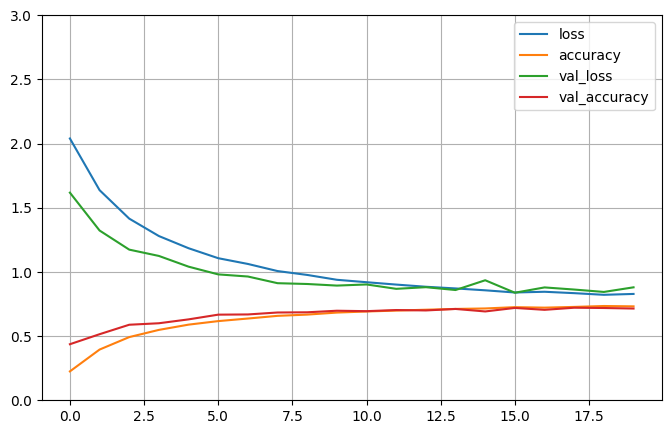

In [ ]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

### Evaluate the model

In [ ]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9280 - accuracy: 0.7089


[0.927987277507782, 0.708899974822998]

## Create a CNN With 3 VGG layer

In [ ]:
model = build_and_compile_model(32,3)

### Show information about the model

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

### Train the model

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1407/1407 [==============================] - 13s 9ms/step - loss: 2.1264 - accuracy: 0.1887 - val_loss: 1.8090 - val_accuracy: 0.3336
Epoch 2/20
1407/1407 [==============================] - 12s 9ms/step - loss: 1.7298 - accuracy: 0.3474 - val_loss: 1.5638 - val_accuracy: 0.4474
Epoch 3/20
1407/1407 [==============================] - 12s 8ms/step - loss: 1.5219 - accuracy: 0.4422 - val_loss: 1.3290 - val_accuracy: 0.5022
Epoch 4/20
1407/1407 [==============================] - 12s 8ms/step - loss: 1.3746 - accuracy: 0.5090 - val_loss: 1.1358 - val_accuracy: 0.5952
Epoch 5/20
1407/1407 [==============================] - 12s 9ms/step - loss: 1.2588 - accuracy: 0.5597 - val_loss: 1.0680 - val_accuracy: 0.6300
Epoch 6/20
1407/1407 [==============================] - 12s 8ms/step - loss: 1.1558 - accuracy: 0.6052 - val_loss: 1.0866 - val_accuracy: 0.6274
Epoch 7/20
1407/1407 [==============================] - 12s 8ms/step - loss: 1.0937 - accuracy: 0.6270 - val_loss: 1.0842 - val_ac

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

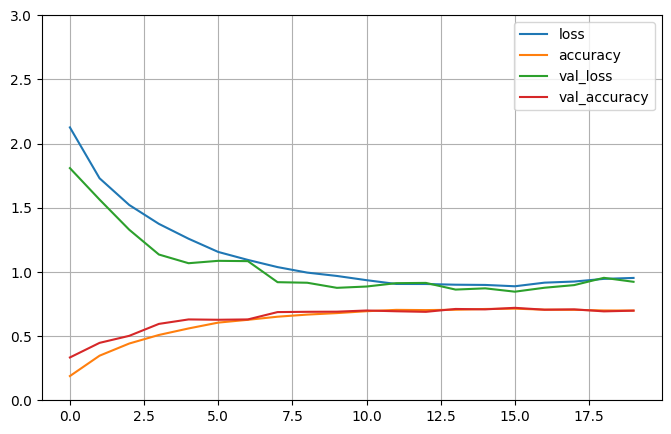

In [ ]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

### Evaluate the model

In [ ]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9551 - accuracy: 0.6875


[0.9551066160202026, 0.6875]